# 6-量子アニーリングによる機械学習

このチュートリアルでは、量子アニーリングの最適化の応用の一例として機械学習(クラスタリング、Qboost)を取り上げます。  
まず、前半部分ではPyQUBOとOpenjijを利用したクラスタリングを行います。  
後半では、PyQUBOとD-Waveのサンプラーを用いてQboostというアンサンブル学習を行います。


## クラスタリング

クラスタリングとは与えられたデータを 𝑛 個のクラスターに分けるというタスクです。( 𝑛 は外部から与えられているとします。)
今回は　クラスター数が2の場合を考えていきます。

In [1]:
# ライブラリのインポート
import numpy as np
from matplotlib import pyplot as plt
from sklearn import cluster
import pandas as pd
from scipy.spatial import distance_matrix 
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import openjij as oj
from sklearn.model_selection import train_test_split

### 人工データを作成する

今回は人工的に、二次元平面上の明らかに線形分離可能なデータを生成し、それをクラスタリングします。

In [2]:
data = []
label = []
for i in range(100):
    p = np.random.uniform(0, 1)
    cls =1 if p>0.5 else -1
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
    
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

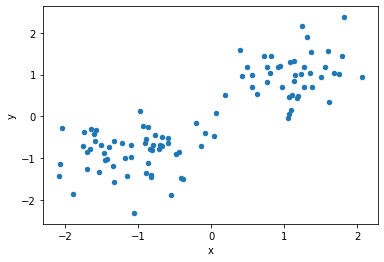

In [3]:
# データセットの確認
df1.plot(kind='scatter', x="x", y="y")
plt.show()

今回は、以下のハミルトニアンを最小化することでクラスタリングを行います。

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j}(1 - \sigma _i \sigma_j)
$$


$i, j$はサンプルの番号、$d_{i,j}$は２つのサンプル間の距離、$\sigma_i=\{-1,1\}$です。この$\sigma _i $は２つのクラスターのどちらかに属しているかを表しています。
このハミルトニアンの和の各項は   
- $\sigma_i  = \sigma_j $のとき、0
- $\sigma_i  \neq \sigma_j $のとき、$d_{i,j}$  

になるので、右辺のマイナスに注意すると、ハミルトニアン全体では「異なるクラスに属しているサンプル同士の距離を最大にする$\{\sigma _1, \sigma _2 \ldots \}$の組を選べ 」という問題に帰着することがわかります。

###  PyQUBOによるクラスタリング

まずは、PyQUBOで上のハミルトニアンを定式化し、さらに、 ``solve_qubo``を用いてシュミレーテッドアニーリングを行います。

In [4]:
def clustering_pyqubo(df):
    # 距離行列
    d_ij = distance_matrix(df, df)

    # spin
    spin = Array.create("spin", shape= len(df), vartype="SPIN")

    # ハミルトニアン
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )

    model = H.compile()
    qubo, offset = model.to_qubo()
    # 解を求める
    raw_solution = solve_qubo(qubo, num_reads=10)

    decoded_solution, broken, energy= model.decode_solution(raw_solution, vartype="SPIN")

    labels = [decoded_solution["spin"][idx] for idx  in range(len(df))]
    return labels, energy

In [5]:
labels, energy =clustering_pyqubo(df1[["x", "y"]])
print("label", labels)
print("energy", energy)

label [0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
energy -7998.514395335311


可視化をしてみましょう

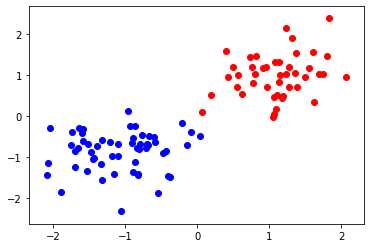

In [6]:
for idx, label in  enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

### Openjijのソルバーを用いたクラスタリング

次はOpenjijのソルバーを用いてクラスタリングをしてみましょう。なお、QUBOの定式化のためにPyQUBOも併用します。

In [7]:
def clustering_openjij(df):
    # 距離行列
    d_ij = distance_matrix(df, df)

    # spin
    spin = Array.create("spin", shape= len(df), vartype="SPIN")

    # ハミルトニアン
    H = - 0.5* sum(
        [d_ij[i,j]* (1 - spin[i]* spin[j]) for i in range(len(df)) for j in range(len(df))]
    )

    model = H.compile()
    qubo, offset = model.to_qubo()
    # 解を求める
    sampler = oj.SQASampler(iteration=10, step_num=100)
    response = sampler.sample_qubo(qubo)
    raw_solution = dict(zip(response.indices, response.states[np.argmin(response.energies)]))


    decoded_solution, broken, energy= model.decode_solution(raw_solution, vartype="SPIN")
    labels = [int(decoded_solution["spin"][idx] ) for idx  in range(len(df))]
    return labels,  sum(response.energies)

In [8]:
labels, energy =clustering_openjij(df1[["x", "y"]])

print("label", labels)
print("energy", energy)

label [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1]
energy -143621.47753649444


こちらも、可視化をしてみましょう。

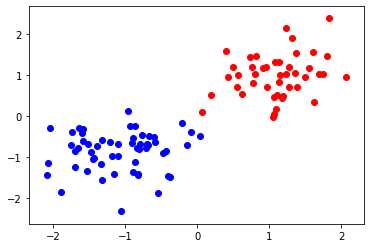

In [9]:
for idx, label in  enumerate(labels):
    if label:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")  
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

## QBoost

QBoostは量子アニーリングを用いたアンサンブル学習の一つです。  
アンサンブル学習は弱い予測器を多数用意して、その予測器の各予測結果の組み合わせて最終的な予測結果を得ます。 
  
QBoostでは、与えられた学習データに対して最適な学習器の組み合わせを量子アニーリングを用いて最適化します。今回は分類問題を扱います。  
まず、$D$個の学習データの集合を$\{\vec x^{(d)}\}(d=1, ..., D)$、対応するラベルを$\{y^{(d)}\}(d=1, ..., D), y^{(d)}\in \{-1, 1\}$とします。また、$N$個の弱学習器の（関数の）集合を$\{C_i\}(i=1, ..., N)$とします。なお、あるデータ$\vec x^{(d)}$　に対して、$C_i(\vec x^{(d)})\in \{-1, 1\}$です。このとき、最終的な分類のラベルは以下のようになります。
$$y^{(d)} ={\rm sgn}\left( \sum_{i=1}^{N} w_i C_i(x_d)\right)  $$
ただし、$w_i\in\{0, 1\} (N=1, ..., N)$とし、各予測器の重み(予測器を最終的な予測に採用するか採用しないかのbool値)とします。  
QBoostではこの$w_i$を弱学習器の個数を刈り込みつつ、最終的な予測が教師データに一致する組み合わせを最適化を行います。
この問題におけるハミルトニアンは、以下のようになります。
$$H(\vec w) = \sum_{d=1}^{D} \left( \frac{1}{N}\sum_{i=1}^{N} w_i C_i(\vec x^{(d)})-y^{(d)} \right)^2 + \lambda \sum _i^N w_i$$
このハミルトニアンの第一項目は弱分類器と正解ラベルの差を表しており、第二項目は最終的な分類器に採用する弱分類器の個数の程度を表しています。なお、$\lambda$は第二項の弱分類器の個数がハミルトニアンにどのくらい影響するかを調節する正則化パラメータになっています。  
このハミルトニアンを量子アニーリングで最小化することにより、学習データに最も適合するような弱分類器の組み合わせを得ることができます。

それでは、実際にQBoostを試してみましょう。今回は、scikit-learnの癌識別のデータセットを使用します。なお、簡単のために、学習に用いるのは"0"と"1"の２つの文字種とします。

In [10]:
# ライブラリをインポート
import pandas as pd 
from scipy import stats 
from sklearn import datasets
from sklearn import metrics

In [11]:
# 今回は2クラスで分類します。
# データのロードを行います。
cancerdata = datasets.load_breast_cancer()
# 学習用データと検証用データの個数です
num_train = 450

今回はデモンストレーションのために、ノイズとなる特徴量がある場合を考えます。

In [12]:
data_noisy= np.concatenate((cancerdata.data, np.random.rand(cancerdata.data.shape[0], 30)), axis=1)
print(data_noisy.shape)

(569, 60)


In [13]:
# labelを{0, 1}から{-1, 1}につけ直します
labels = (cancerdata.target -0.5 )*2

In [14]:
# データセットを学習用と検証用に分割します
X_train =data_noisy[:num_train, :]
X_test = data_noisy[num_train:, :]
y_train = labels[:num_train]
y_test = labels[num_train:]

In [15]:
# 弱学習器の結果から
def aggre_mean(Y_list):
    return ( (np.mean(Y_list,  axis=0) > 0) - 0.5) *2

### 弱学習器の作成

ます、はじめにscikit-learnで弱分類器を作成します。今回は、弱分類器として、decision stumpを用います。decision stumpとは、一層の決定木のことを指します。今回は、弱分類器として用いるので分割に用いる特徴量はランダムに選ぶこととします。(一層のランダムフォレストを行うという理解で良いと思います。)

In [16]:
num_clf = 32 #弱分類機の個数
sample_train = 40 # bootstrap samplingで一つのサンプルに対して取り出すサンプルの個数

from sklearn.tree import DecisionTreeClassifier as DTC

models = [ DTC(splitter="random",max_depth=1) for i in range(num_clf)]

for model in models:
    train_idx = np.random.choice(np.arange(X_train.shape[0]), sample_train)
    model.fit(X=X_train[train_idx], y=y_train[train_idx])
    
y_pred_list_train = []
for model in models:
    y_pred_list_train.append(model.predict(X_train))
    
y_pred_list_train = np.asanyarray(y_pred_list_train)
y_pred_train =np.sign(y_pred_list_train)

すべての弱学習器を最終的な分類器として、精度を見てみましょう。以後、この組み合わせをbaselineとします。

In [17]:
y_pred_list_test = []
for model in models:
    y_pred_list_test.append(model.predict(X_test))
    
y_pred_list_test = np.array(y_pred_list_test)
y_pred_test = np.sign(np.sum(y_pred_list_test,axis=0))

acc_test_base = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(acc_test_base)

0.957983193277311


### PyQUBOでQUBOを定義する

In [18]:
class QBoost():
    def __init__(self, y_train, ys_pred):
        self.num_clf = ys_pred.shape[0]
        # spinを定義
        self.Ws = Array.create("weight", shape = self.num_clf, vartype="BINARY")

        # 正規化項の大きさ
        self.param_lamda = Placeholder("norm")

        #　弱分類器の組み合わせのハミルトニアン
        self.H_clf = sum( [ (1/self.num_clf * sum([W*C for W, C in zip(self.Ws, y_clf)])- y_true)**2 for y_true, y_clf in zip(y_train, ys_pred.T)
        ])
 
        # 正規化項のハミルトニアン
        self.H_norm = Constraint(sum([W for W in self.Ws]), "norm")

        # ハミルトニアンの全体
        self.H = self.H_clf + self.H_norm * self.param_lamda

        # モデルをコンパイル
        self.model = self.H.compile()
        
    def to_qubo(self, norm_param= 1):
        self.feed_dict = {'norm': norm_param}
        return self.model.to_qubo(feed_dict=self.feed_dict)
       

In [19]:
qboost = QBoost(y_train=y_train, ys_pred=y_pred_list_train)
qubo = qboost.to_qubo(3)[0]

### D-WaveサンプラーでQBoostを実行する

In [20]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

In [21]:
# サンプラーを設定
endpoint = 'https://cloud.dwavesys.com/xxxxxxxxxxx'
token = "xxxxxxxxxxxxxxxxxxxxxxxx"
solver = 'xxxxxxxxxxxxxxxxxxxxxxx
sampler = EmbeddingComposite(DWaveSampler(endpoint=endpoint, token=token, solver=solver))

In [22]:
# 計算を実行
# num_readsで何回D-Waveのサンプラーで計算を実行するかを指定します
sampleset = sampler.sample_qubo(qubo, num_reads=100)

In [23]:
# 結果を確認します
print(sampleset)

Response(rec.array([([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], -257.12304688, 4, 0.375  ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], -254.76367188, 2, 0.375  ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], -253.3984375 , 2, 0.40625),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], -257.02734375, 1, 0.375  ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], -256.23242188, 2, 0.40625),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], -257.12304688, 1, 0.375  ),
           ([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], -254.76367188, 1, 0.375  ),
           ([1, 1, 1, 1, 

In [24]:
# openjijのconvert_responseでPyQUBOでdecode可能な形式に変換
response= oj.convert_response(sampleset)

In [25]:
# 各計算結果についてPyQUBOでdecodeします
decoded_solutions = []
brokens = []
energies =[]
for sample in response.samples:
    # pyquboのdecoded_solutionでデコードされた解、壊れたスピン、エネルギーを得る
    decoded_solution, broken, energy= qboost.model.decode_solution(sample, vartype="BINARY", feed_dict=qboost.feed_dict)
    decoded_solutions.append(decoded_solution)
    brokens.append(broken)
    energies.append(energy)

D-Waveで得られた弱分類器の組み合わせを使った場合の、学習データ/検証データでの精度を確認しましょう

In [26]:
accs_train_Dwaves = []
accs_test_Dwaves = []


for decoded_solution in decoded_solutions:
    idx_clf_DWave=[]
    for key, val in decoded_solution["weight"].items():
        if val == 1:
            idx_clf_DWave.append(int(key))
            
    y_pred_train_DWave = np.sign(np.sum(y_pred_list_train[idx_clf_DWave, :], axis=0))
    y_pred_test_DWave = np.sign(np.sum(y_pred_list_test[idx_clf_DWave, :], axis=0))
    acc_train_DWave = metrics.accuracy_score(y_true=y_train, y_pred=y_pred_train_DWave)
    acc_test_DWave= metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test_DWave)
    accs_train_Dwaves.append(acc_train_DWave)
    accs_test_Dwaves.append(acc_test_DWave)


エネルギーと精度の関係をグラフにしてみましょう。

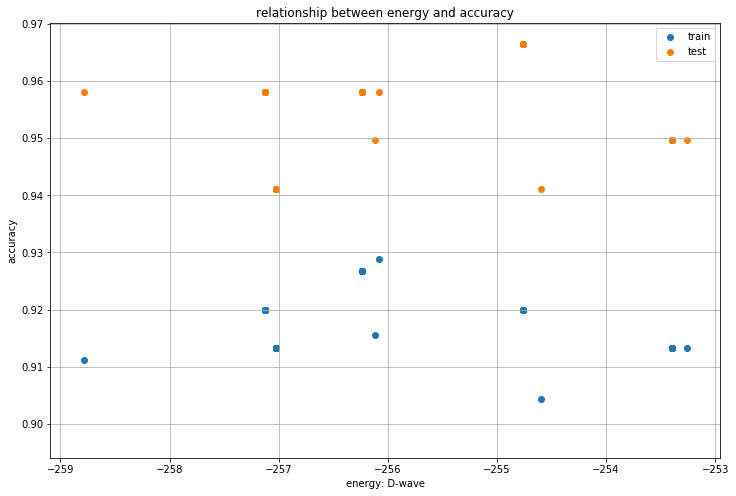

In [27]:
plt.figure(figsize=(12, 8))
plt.scatter(response.energies, accs_train_Dwaves, label="train" )
plt.scatter(response.energies, accs_test_Dwaves, label="test")
plt.xlabel("energy: D-wave")
plt.ylabel("accuracy")
plt.title("relationship between energy and accuracy")
plt.grid()
plt.legend()
plt.show()

In [28]:
print("base accuracy is {}".format(acc_test_base))
print("max accuracy　of QBoost is {}".format(max(accs_test_Dwaves)))
print("average accuracy　of QBoost is {}".format(np.mean(np.asarray(accs_test_Dwaves))))

base accuracy is 0.957983193277311
max accuracy　of QBoost is 0.9663865546218487
average accuracy　of QBoost is 0.9542016806722686


D-Waveによるサンプリングは短時間で数百サンプリング以上サンプリングできるので、精度が最大になる結果を使えば、baselineよりも高精度の分類器を作成できます。